In [3]:
#!pip install catboost
#!pip install shap

 # 1- Import Libraries

In [202]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
color_pal = sns.color_palette()

import shap
import xgboost
import optuna
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor , AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier as cb
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier,XGBRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeClassifier, RidgeClassifierCV
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTENC


import warnings
warnings.filterwarnings('ignore')

seed = 77

# 2- Read Dataset

In [171]:
ha = pd.read_csv('/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv')
ha

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


# 3- Missing Value

In [6]:
total = ha.isnull().sum().sort_values(ascending=False)
percent = (ha.isnull().sum() / ha.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent*100], axis=1, keys=["Total", "Percent(%)"])
missing_data

,Total,Percent(%)
age,0,0.0
sex,0,0.0
cp,0,0.0
trtbps,0,0.0
chol,0,0.0
fbs,0,0.0
restecg,0,0.0
thalachh,0,0.0
exng,0,0.0
oldpeak,0,0.0


# 4- Check Duplicates

In [7]:
duplicates = ha[ha.duplicated()]
print("Total Duplicates rows observed:", duplicates.shape[0])
print("Dropping duplicates")


print("Shape before dropping duplicates: ", ha.shape[0])
ha.drop_duplicates(inplace=True)
print("Shae after dropping duplicates: ", ha.shape[0])

Total Duplicates rows observed: 1
Dropping duplicates
Shape before dropping duplicates:  303
Shae after dropping duplicates:  302


# 5- Statistics

In [18]:
ha.describe(percentiles=[0.1, 0.25, 0.75, 0.9, 0.95]).T

,count,mean,std,min,10%,25%,50%,75%,90%,95%,max
age,302.0,54.420530,9.047970,29.0,42.0,48.00,55.5,61.00,66.0,68.00,77.0
sex,302.0,0.682119,0.466426,0.0,0.0,0.00,1.0,1.00,1.0,1.00,1.0
cp,302.0,0.963576,1.032044,0.0,0.0,0.00,1.0,2.00,2.0,3.00,3.0
trtbps,302.0,131.602649,17.563394,94.0,110.0,120.00,130.0,140.00,152.0,160.00,200.0
chol,302.0,246.500000,51.753489,126.0,188.4,211.00,240.5,274.75,308.9,326.95,564.0
fbs,302.0,0.149007,0.356686,0.0,0.0,0.00,0.0,0.00,1.0,1.00,1.0
restecg,302.0,0.526490,0.526027,0.0,0.0,0.00,1.0,1.00,1.0,1.00,2.0
thalachh,302.0,149.569536,22.903527,71.0,116.0,133.25,152.5,166.00,176.8,181.95,202.0
exng,302.0,0.327815,0.470196,0.0,0.0,0.00,0.0,1.00,1.0,1.00,1.0
oldpeak,302.0,1.043046,1.161452,0.0,0.0,0.00,0.8,1.60,2.8,3.40,6.2


# 6- Unique Values

In [11]:
num_cols = ['age','sex', 'cp','trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output']

print(f"[Unique Values in {len(num_cols)} Numerical Variables]\n")

for num_col in num_cols:
    print("* {} : {} Unique Values".format(num_col, ha[num_col].nunique()))

[Unique Values in 14 Numerical Variables]

* age : 41 Unique Values
* sex : 2 Unique Values
* cp : 4 Unique Values
* trtbps : 49 Unique Values
* chol : 152 Unique Values
* fbs : 2 Unique Values
* restecg : 3 Unique Values
* thalachh : 91 Unique Values
* exng : 2 Unique Values
* oldpeak : 40 Unique Values
* slp : 3 Unique Values
* caa : 5 Unique Values
* thall : 4 Unique Values
* output : 2 Unique Values


# 7- Visualization

<Axes: title={'center': 'Heart Atack'}>

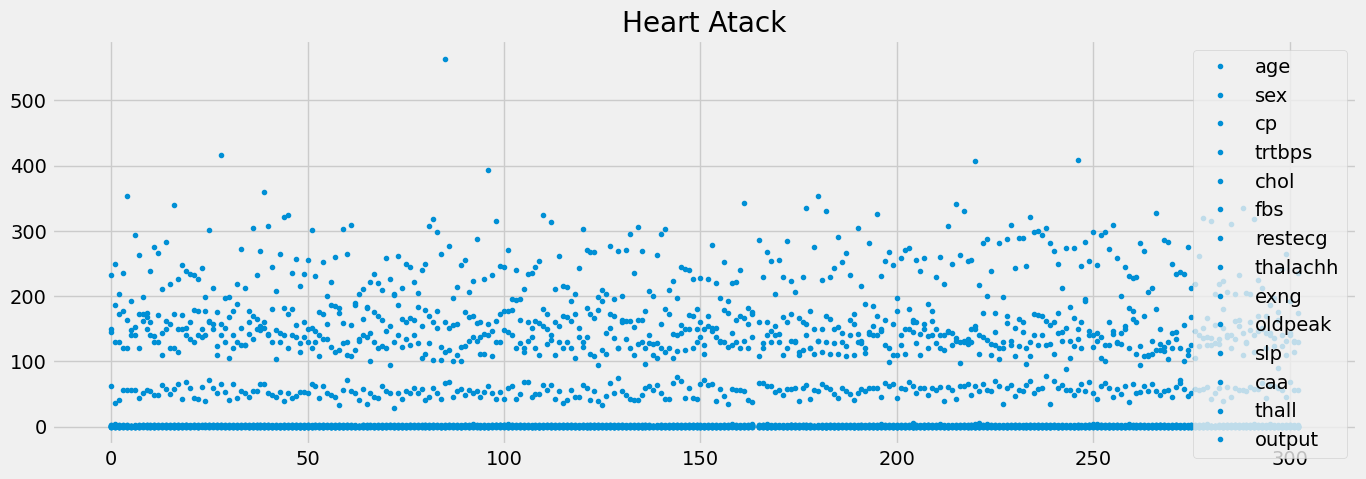

In [21]:
ha.plot(figsize=(15,5),style='.',color=color_pal[0],title='Heart Atack')

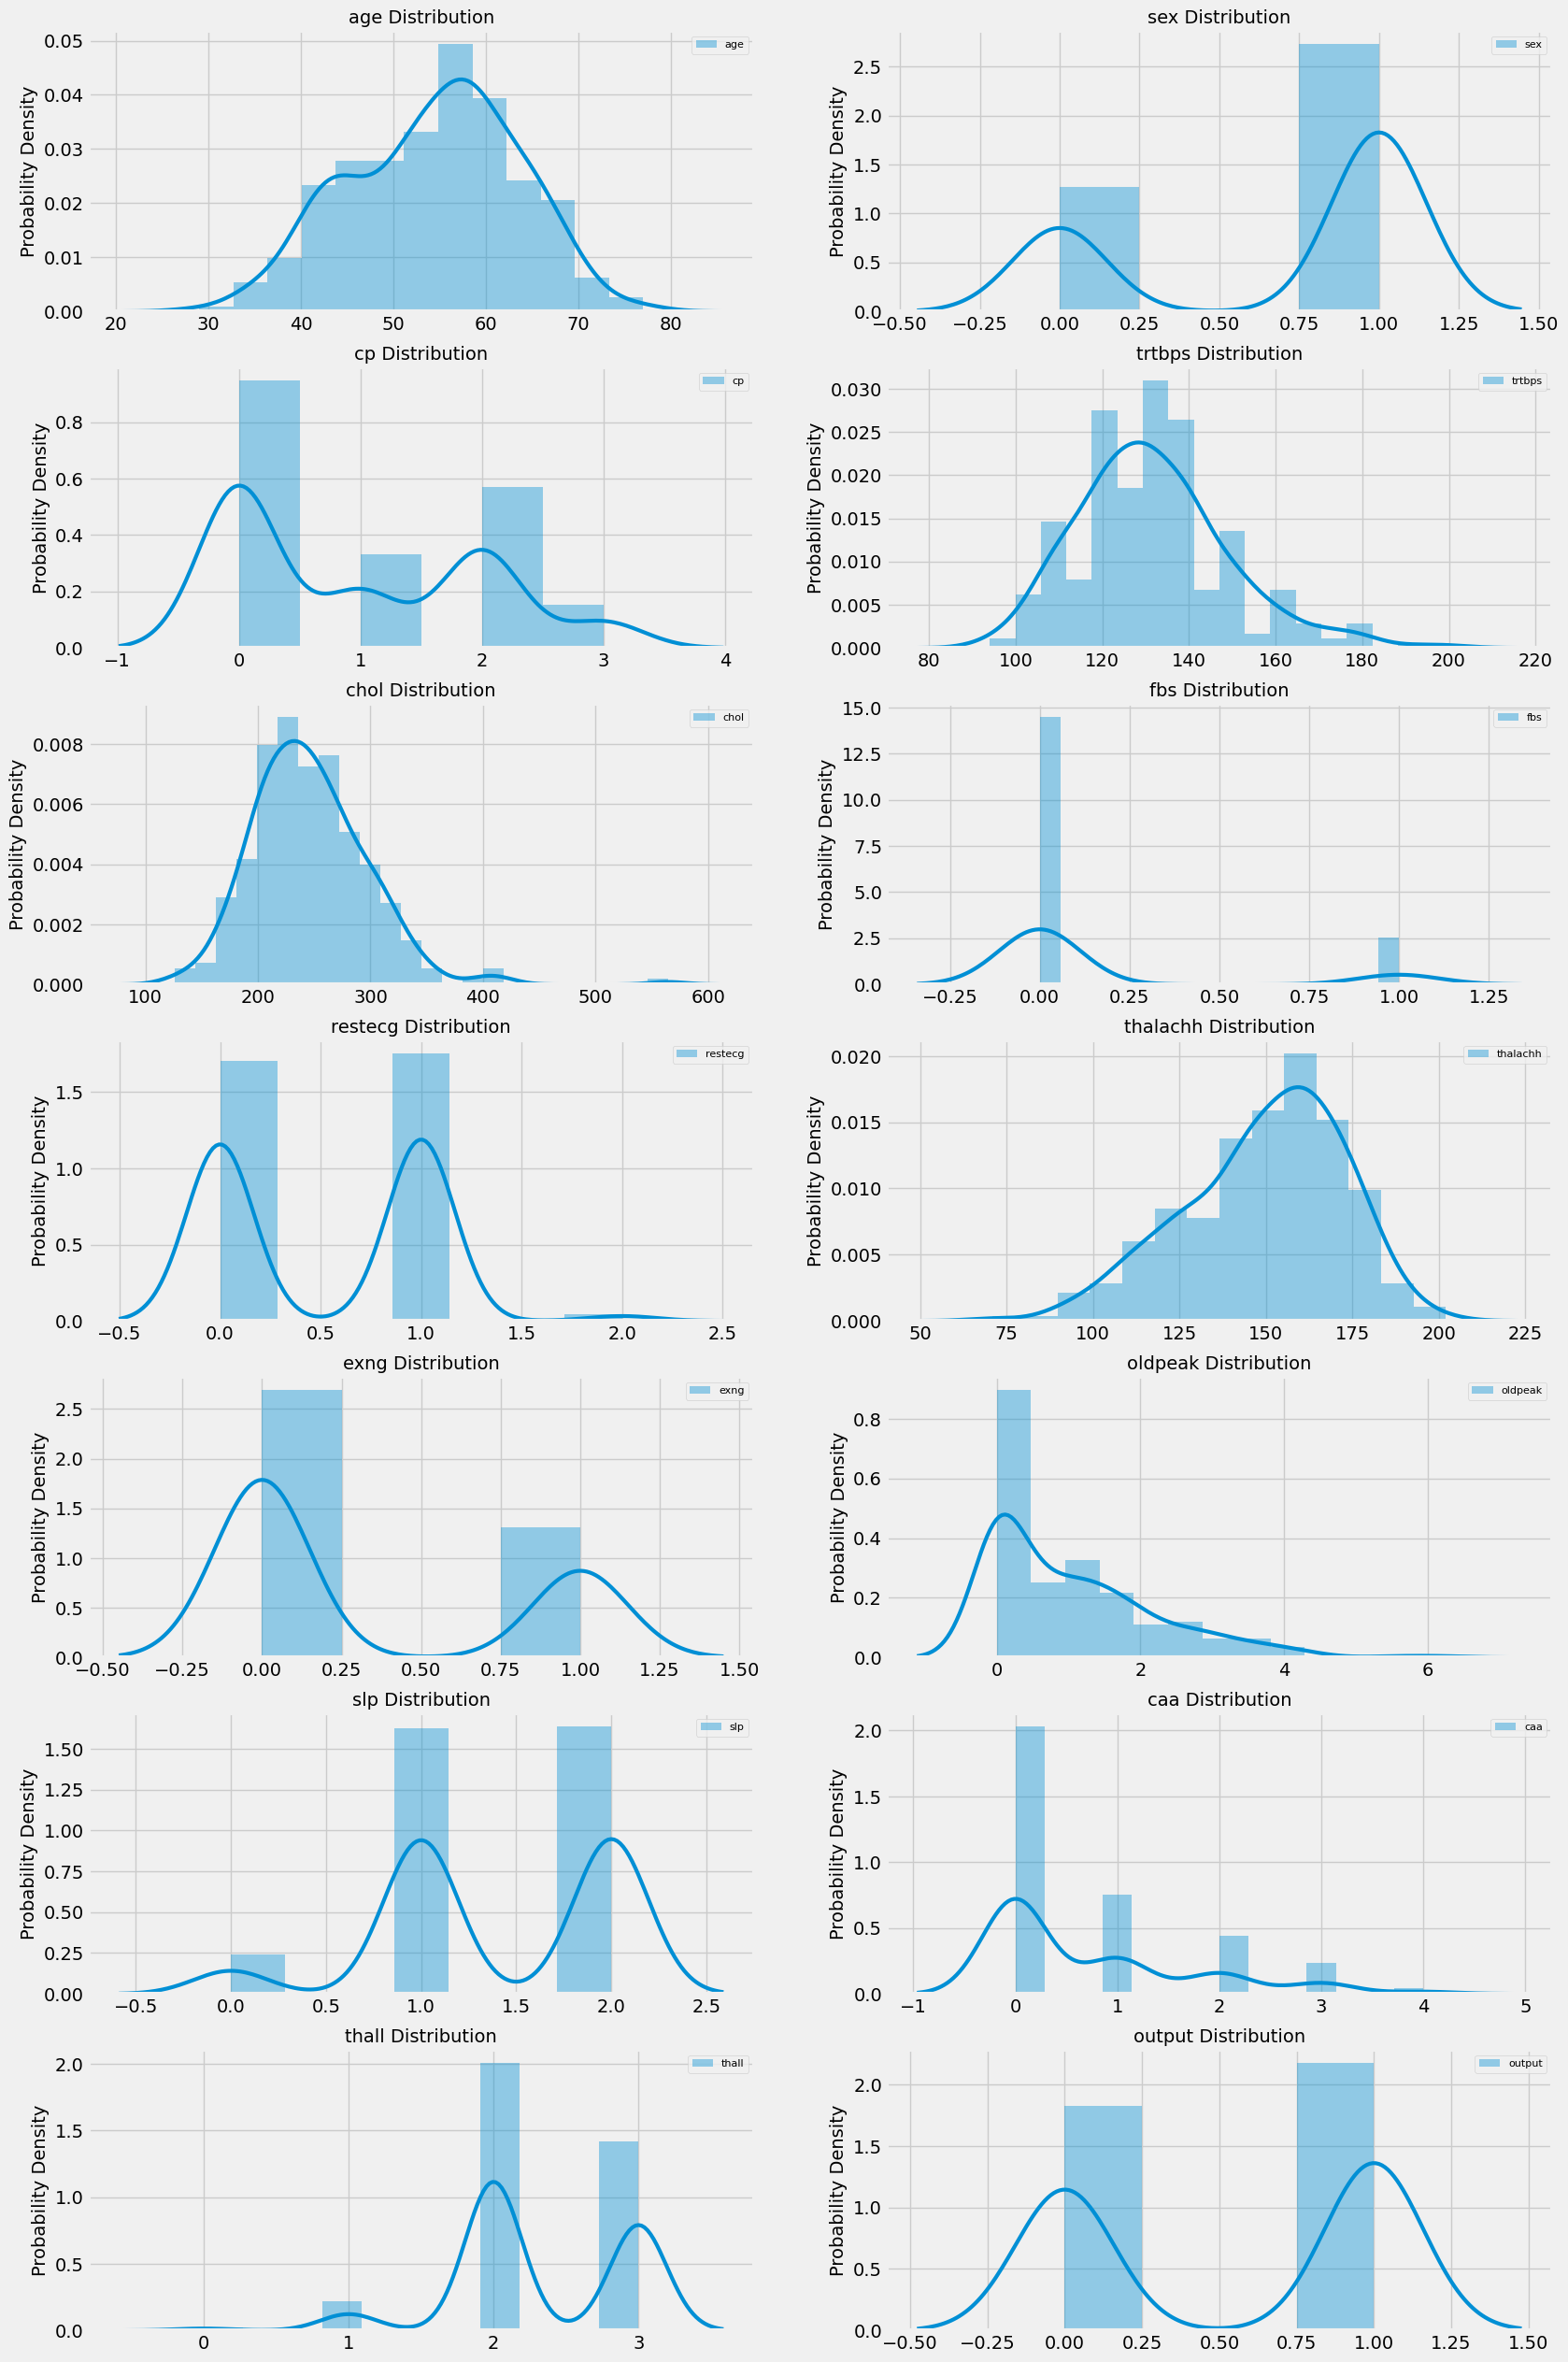

In [28]:
n_rows, n_cols = 7, 2

fig, ax = plt.subplots(n_rows, n_cols, figsize=(18,20))

for i, num_col in enumerate(num_cols):
    i, j = i//n_cols, i%n_cols
    
    figure = sns.distplot(ha[num_col], label=num_col, norm_hist=True, ax=ax[i,j], kde_kws={"lw":3})
    figure = figure.legend(loc='best', fontsize=8)
        
    ax[i,j].set_title(f'{num_col} Distribution', fontsize=14)
    ax[i,j].set_ylabel("Probability Density", fontsize="medium")
    ax[i,j].set_xlabel("")

fig.subplots_adjust(top=1.3)
fig.show()

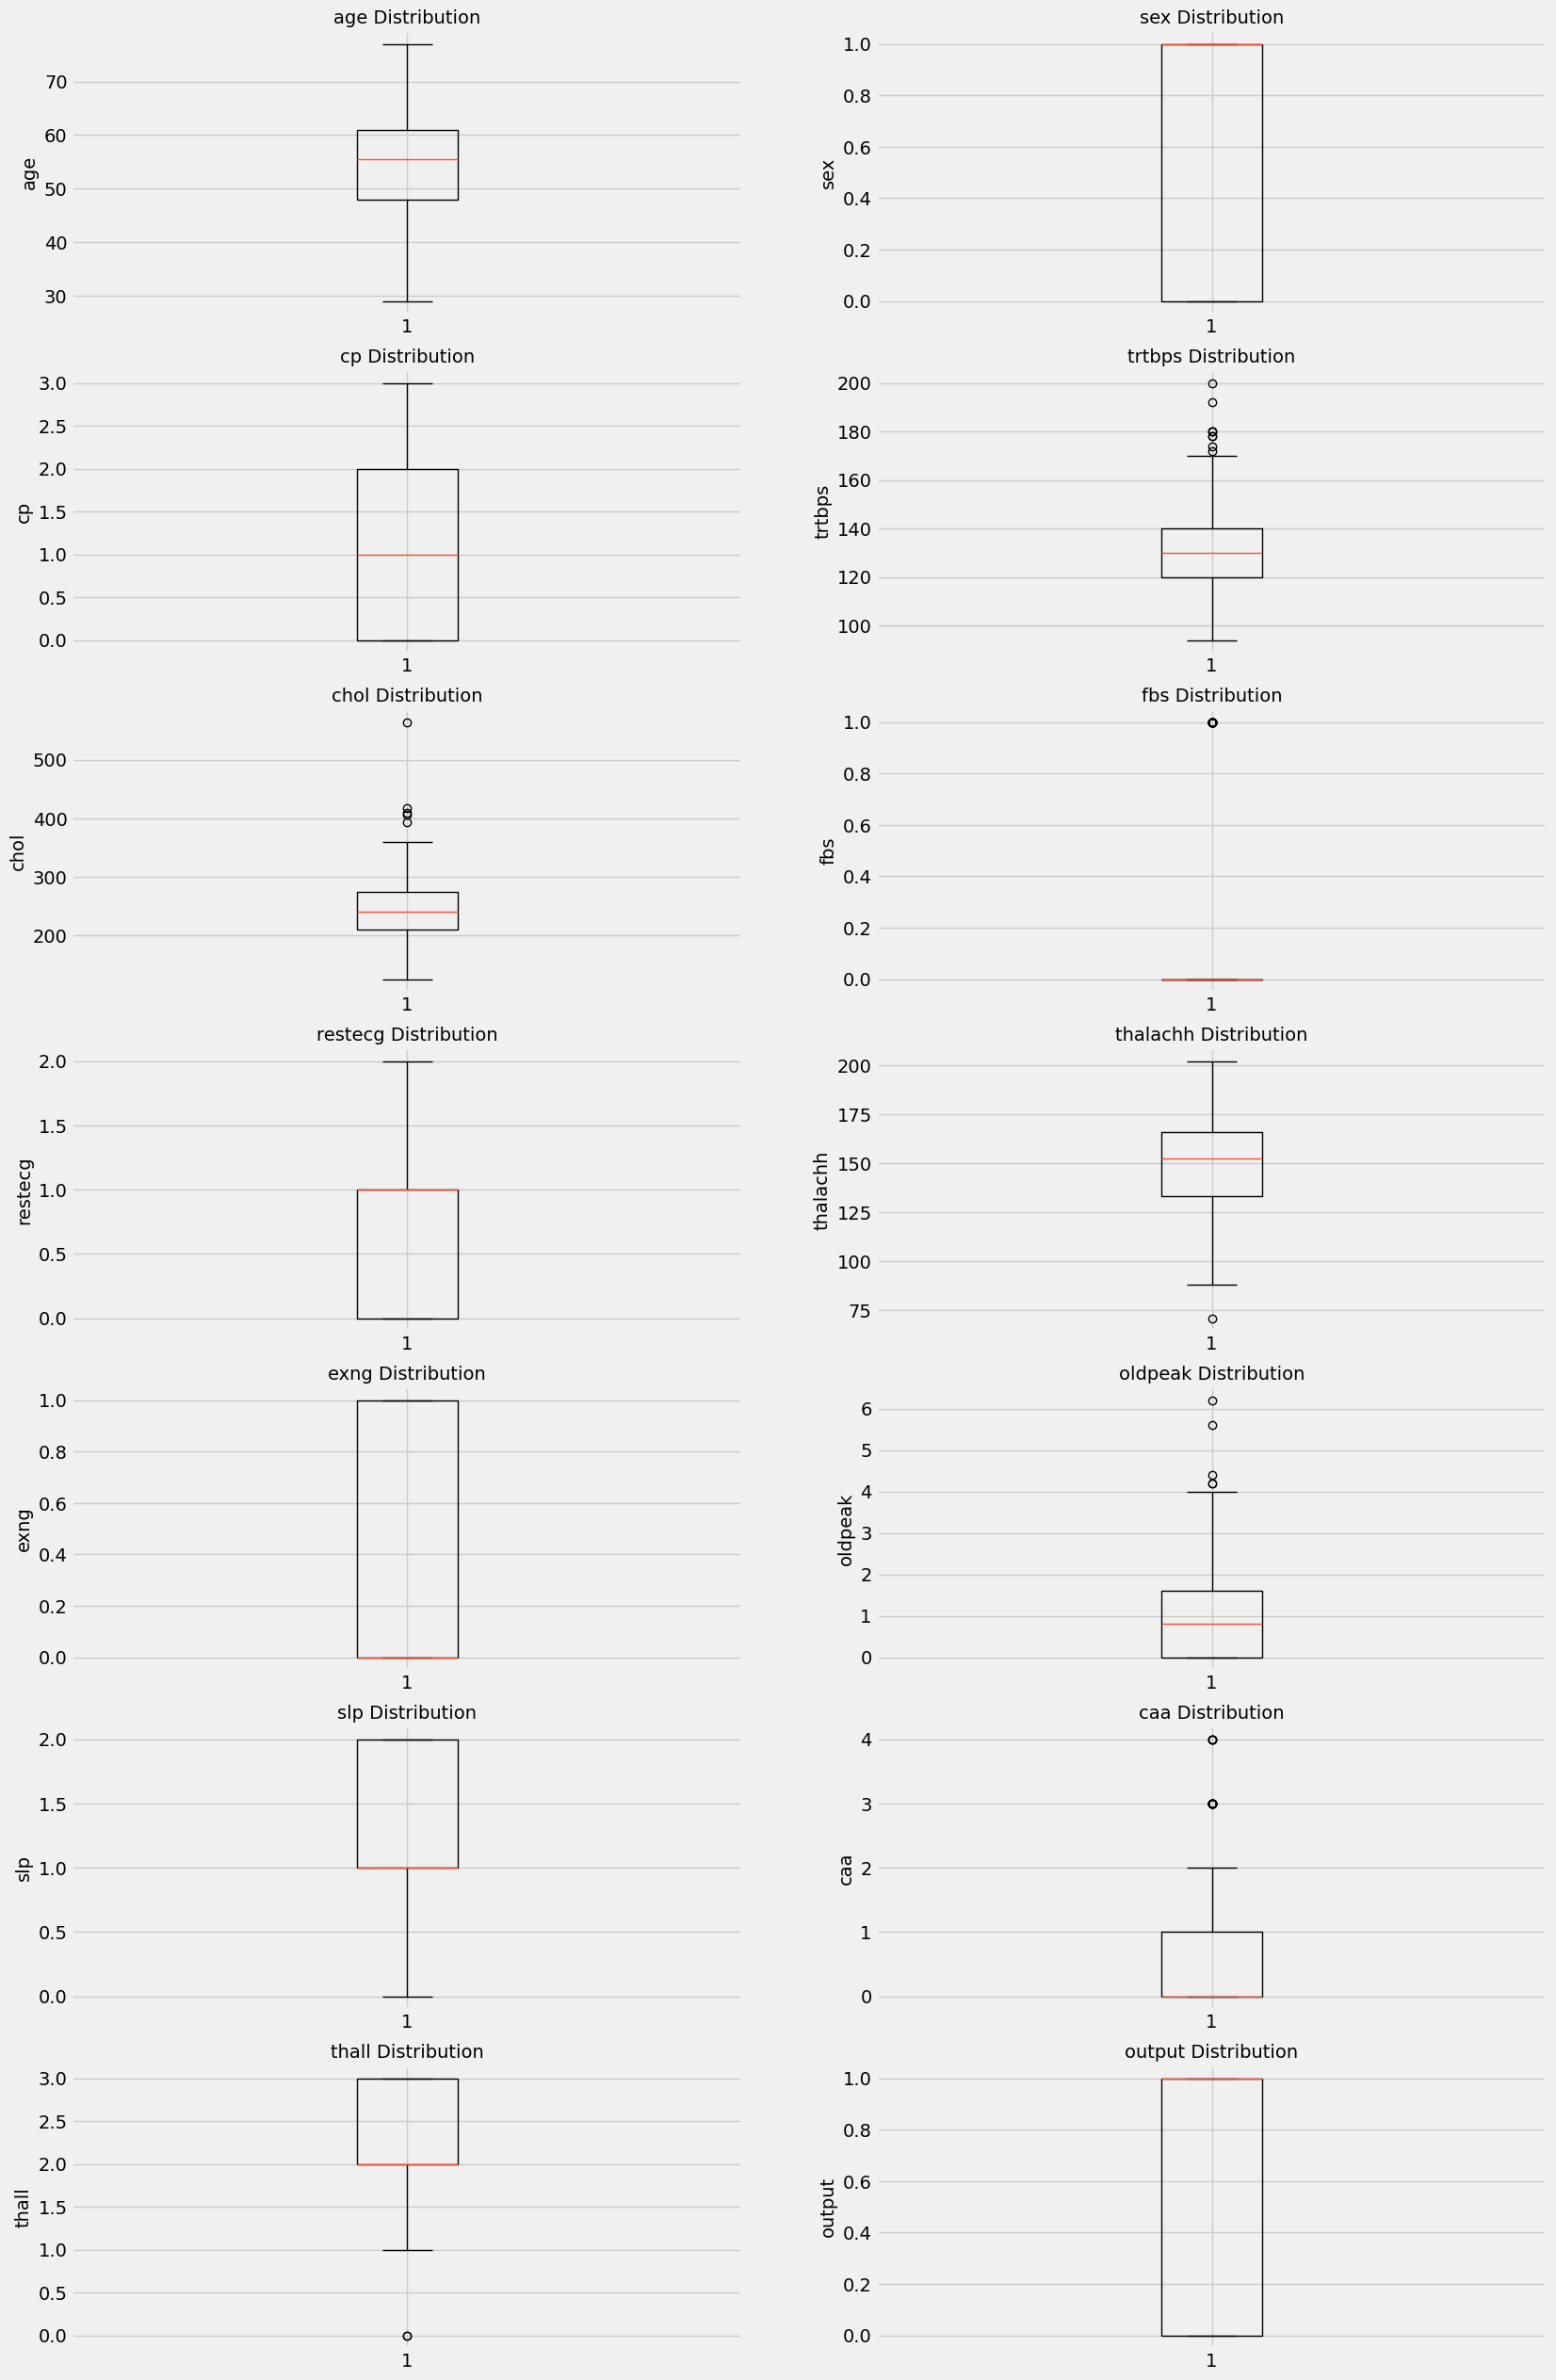

In [29]:
n_rows, n_cols = 7, 2

fig, ax = plt.subplots(n_rows, n_cols, figsize=(18,20))

for i, num_col in enumerate(num_cols):
    i, j = i//n_cols, i%n_cols
        
    ax[i,j].set_title(f'{num_col} Distribution', fontsize=14)
    ax[i,j].set_ylabel(f"{num_col}", fontsize="medium")
    ax[i,j].set_xlabel("")
    
    ax[i,j].boxplot(ha[num_col])

fig.subplots_adjust(top=1.3)
fig.show()

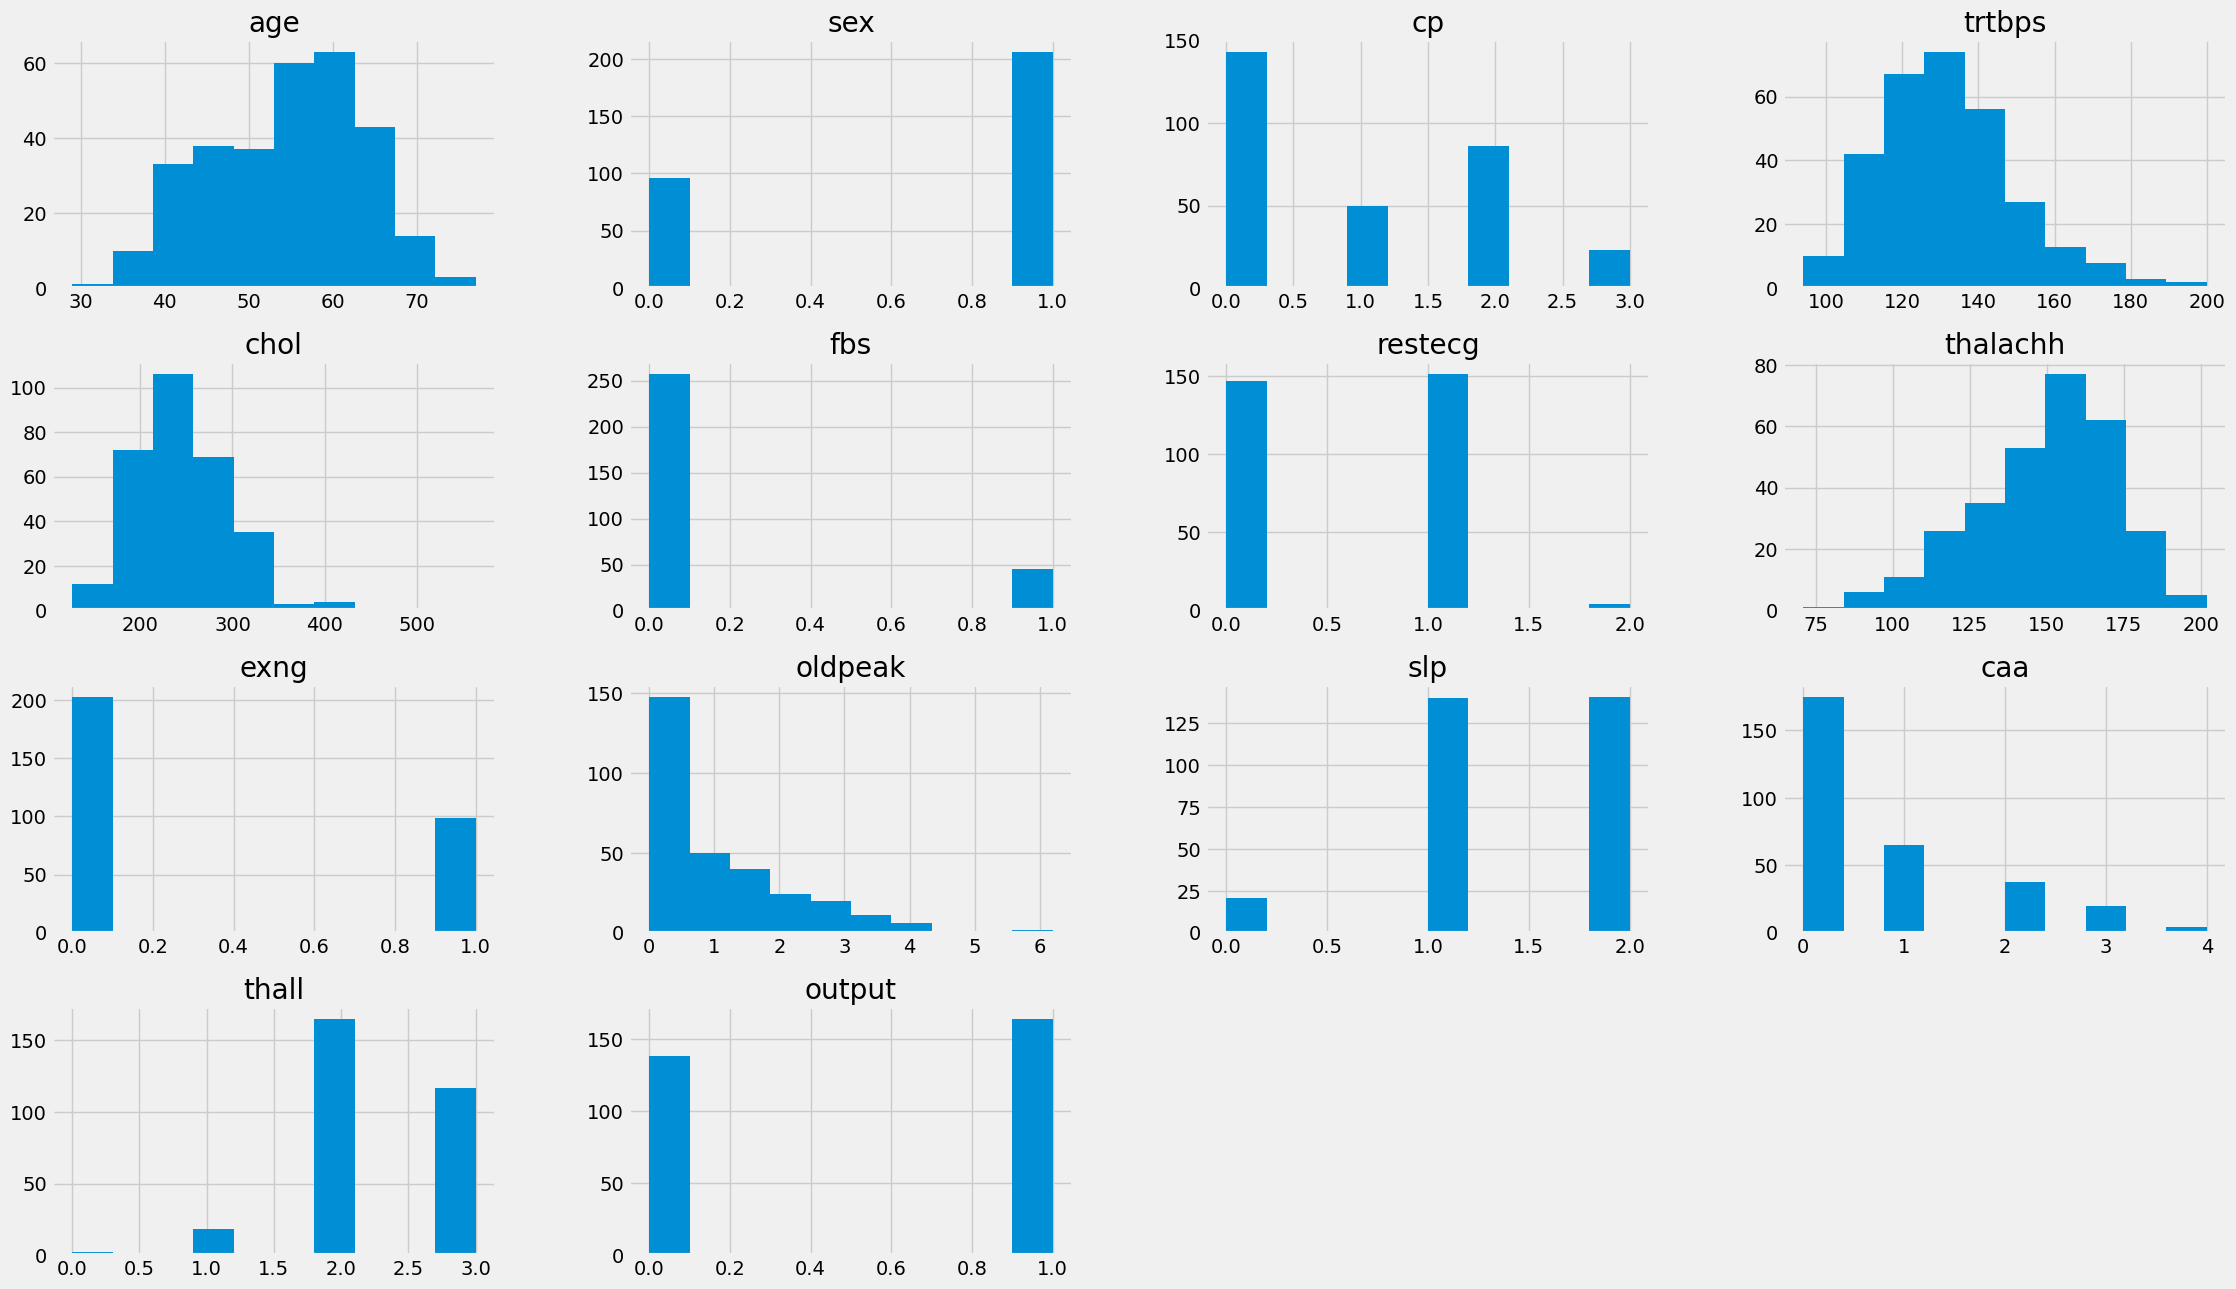

In [47]:
ha.hist(figsize=(25,15))
plt.show()

In [267]:
ha.corr()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trtbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalachh,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exng,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


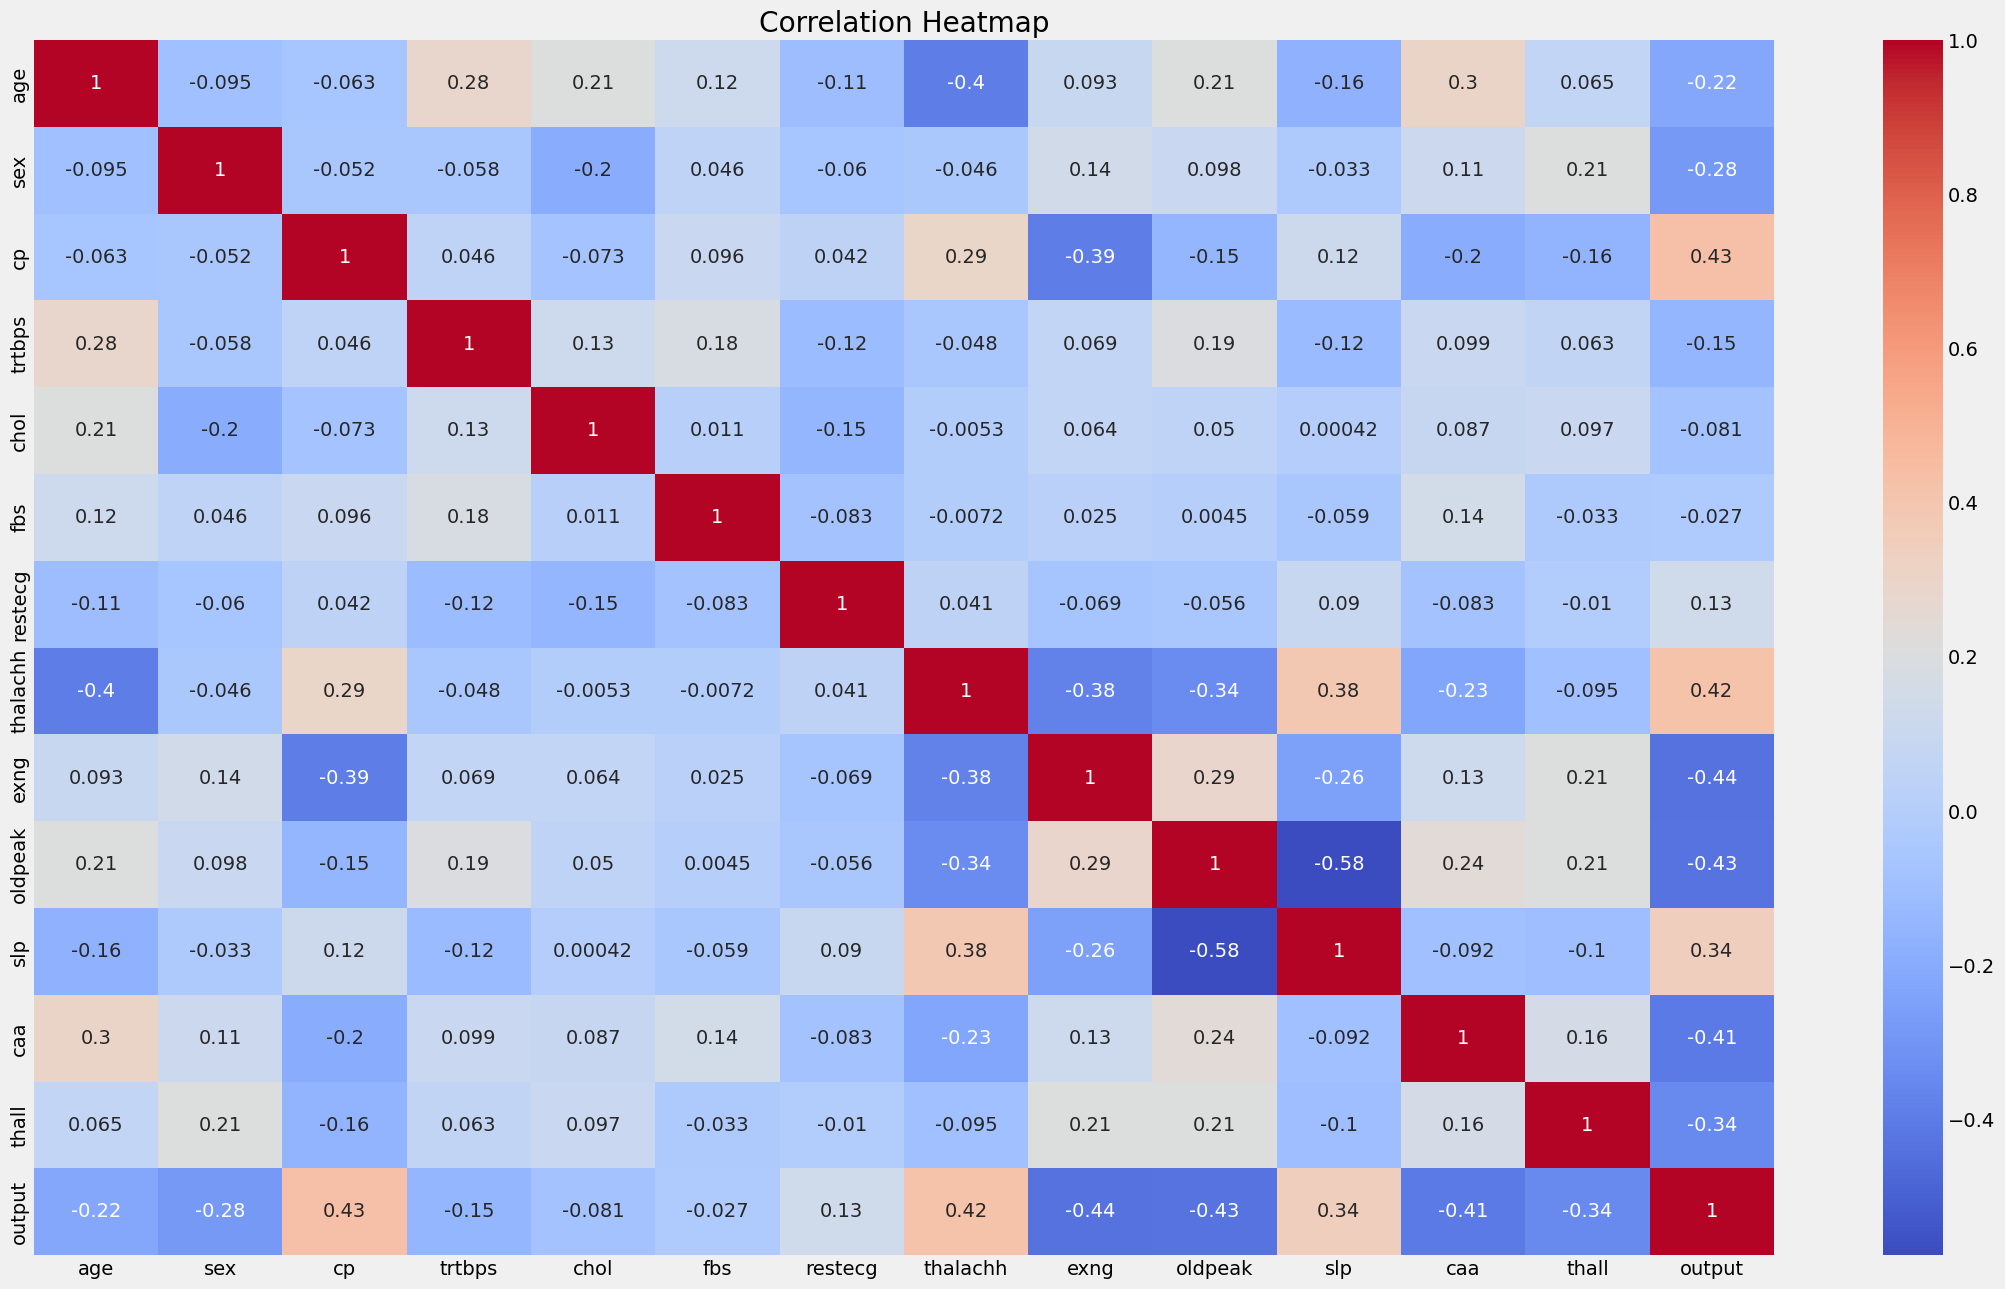

In [48]:
plt.figure(figsize=(25, 15))
correlation_matrix = ha.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

<Axes: xlabel='sex', ylabel='count'>

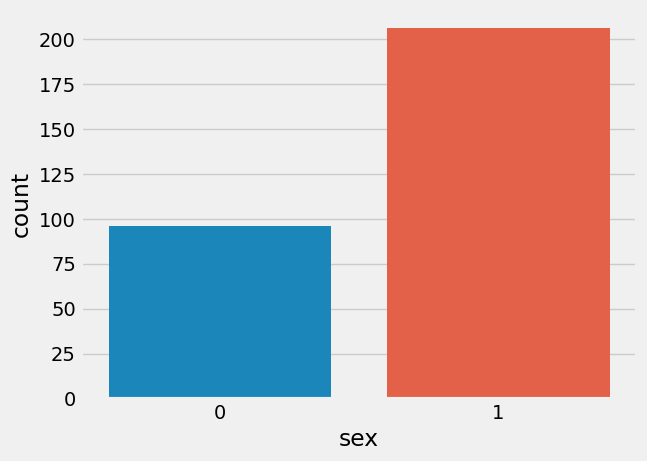

In [52]:
sns.countplot(x='sex', data=ha)

# 8- ML

# 8.1- Train_Test_Split

In [162]:
x = ha.drop("output", axis=1)
y = ha['output']

In [140]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=seed)

print("Training Data Shape : ", xtrain.shape, ytrain.shape)
print("Test Data Shape : ", xtest.shape, ytest.shape)

Training Data Shape :  (241, 13) (241,)
Test Data Shape :  (61, 13) (61,)


# 8.2- ML Classic Models

In [142]:
model_params = {
    'linear_regression':{
        'model':LinearRegression(),
        'params':{
            
        }
    },
    'Decision_Tree':{
        'model':DecisionTreeRegressor(),
        'params':{
            'max_depth':[10,20,50,100],
            'random_state':[0,42]
        }
    },
    'Random_Forest':{
        'model':RandomForestRegressor(),
        'params':{
            'n_estimators':[10,20,50,100,200]
        }
    },
    'Ridge_regression':{
        'model':Ridge(tol=0.1),
        'params':{
             'alpha':[1,10,20,50,100],
            'max_iter':[50,100,200]
        }
    },
    'Lasso_regression':{
        'model':Lasso(tol=0.1),
        'params':{
            'alpha':[1,10,20,50,100],
            'max_iter':[50,100,200]
        }
    }
    
    
}

In [143]:
score=[]
best_score = 0
second_best_score = 0
best_model = None        # This is the best model in the end of the grid search cv
second_best_model = None #This is the second best model in the end of the grid search cv
for model_name,m in model_params.items():
    clf = GridSearchCV(m['model'],m['params'],cv=5)
    clf.fit(xtrain,ytrain)
    
    if best_score<clf.best_score_:
        second_best_score =  best_score
        second_best_model =  best_model
        best_score = clf.best_score_
        best_model = clf.best_estimator_
    elif clf.best_score_>second_best_score:
        second_best_score = clf.best_score_
        second_best_model = clf.best_estimator_
    
    score.append({
        'model':model_name,
        'score':clf.best_score_,
        'param':clf.best_params_
    })
    

pd.DataFrame(score)

,model,score,param
0,linear_regression,0.402321,{}
1,Decision_Tree,0.032768,"{'max_depth': 20, 'random_state': 42}"
2,Random_Forest,0.427842,{'n_estimators': 100}
3,Ridge_regression,0.407485,"{'alpha': 10, 'max_iter': 50}"
4,Lasso_regression,0.120835,"{'alpha': 1, 'max_iter': 50}"


# 8.3- ML Modern Models

# 8.4- XGBoost

In [176]:
def objective(trial):
    params = {
        "objective": "binary:logistic",
        'verbosity': 0,
        "eval_metric": "logloss",
        "tree_method": "gpu_hist",
        "booster": "gbtree",
        "random_state" : seed,
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "subsample": trial.suggest_float("subsample", 0.1, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.01, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 10),
        "n_estimators": trial.suggest_int("n_estimators", 50, 3000, step=50),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 10),
        "grow_policy": trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    }
    
    model = XGBClassifier(**params)
    xgb_model = model.fit(X_train, y_train)
    
    pred = xgb_model.predict(X_valid)
    pred_proba = xgb_model.predict_proba(X_valid)[:, 1]
    score = f1_score(y_valid, pred)
    #score = accuracy_score(y_valid, pred)
    #score = precision_score(y_valid, pred)
    #score = recall_score(y_valid, pred)
    #score = roc_auc_score(y_valid, pred_proba)
    
    return score

## 8.4.1- Training Model

In [177]:
optuna_switch = False

if optuna_switch == True:
    study_xgb = optuna.create_study(direction='maximize')
    study_xgb.optimize(objective, n_trials = 50, show_progress_bar=True)
    
    
if optuna_switch == True:
    print("Best Hyperparameters: ", study_xgb.best_params)
    print("Best F1 Score: ", study_xgb.best_value)

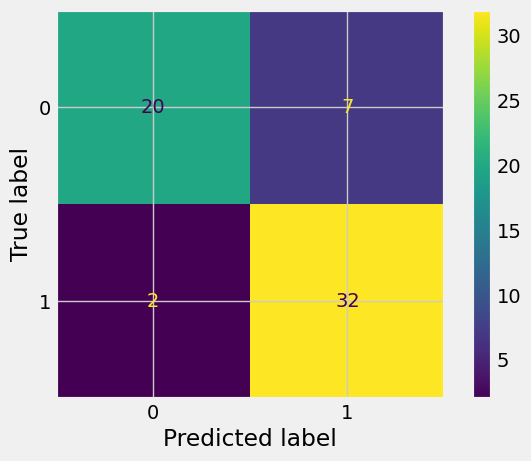

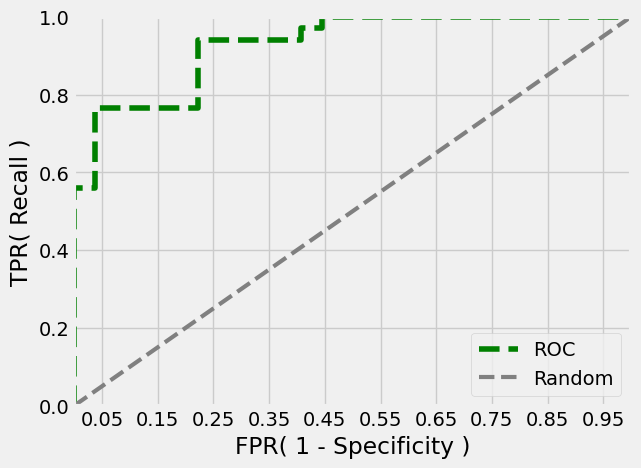

In [180]:
if optuna_switch == True:
    xgb = XGBClassifier(random_state=seed, **study_xgb.best_params)
else:
    xgb = XGBClassifier(random_state=seed, max_depth = 4, subsample = 0.8455445119537031, colsample_bytree = 0.7473353578505076, learning_rate = 0.2343253699229094, min_child_weight = 1, gamma = 0.3290797801781987, reg_alpha = 1.0280651442885607, reg_lambda = 2.990770634501404, n_estimators = 2450, scale_pos_weight = 1.1196755081865422, grow_policy = 'lossguide')
                        
xgb_model = xgb.fit(xtrain, ytrain)

pred = xgb_model.predict(xtest)
pred_proba = xgb_model.predict_proba(xtest)[:, 1]
metrics_train_xgb = get_clf_eval(ytest.values, pred, pred_proba)

In [181]:
fig = go.Figure()
fig.add_trace(
    go.Table(columnwidth=[80,100],
             header=dict(values=['Metrics', 'XGBoost_Train'], height=50, font_size=22),
             cells=dict(values=[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC_AUC'],
                                [metrics_train_xgb['accuracy'].round(3), metrics_train_xgb['precision'].round(3), metrics_train_xgb['recall'].round(3), metrics_train_xgb['f1'].round(3), metrics_train_xgb['roc_auc'].round(3)]], height=50, font_size=16)))

fig.show()

## 8.4.2- Evaluate The Model

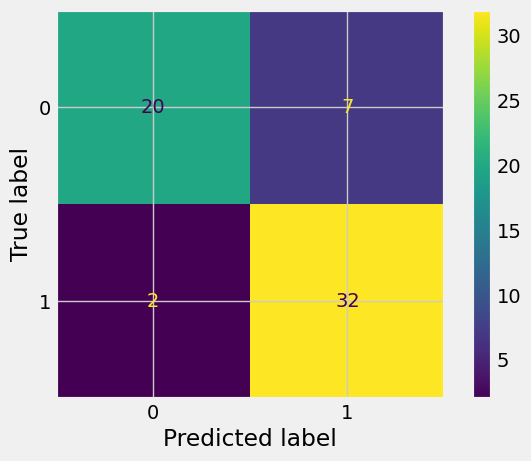

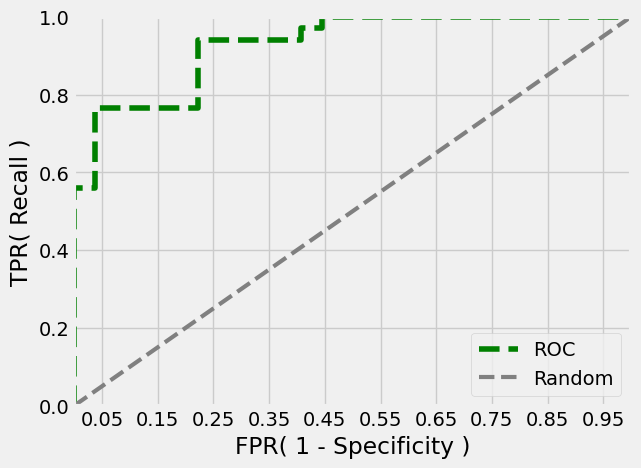

In [182]:
pred = xgb_model.predict(xtest)
pred_proba = xgb_model.predict_proba(xtest)[:, 1]
metrics_test_xgb = get_clf_eval(ytest.values, pred, pred_proba)

In [183]:

fig = go.Figure()
fig.add_trace(
    go.Table(columnwidth=[80,100],
             header=dict(values=['Metrics', 'XGBoost_Test'], height=50, font_size=22),
             cells=dict(values=[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC_AUC'],
                                [metrics_test_xgb['accuracy'].round(3), metrics_test_xgb['precision'].round(3), metrics_test_xgb['recall'].round(3), metrics_test_xgb['f1'].round(3), metrics_test_xgb['roc_auc'].round(3)]], height=50, font_size=16)))

fig.show()

# 8.5 - LightGBM

In [187]:
def objective(trial):
    params = {
        "verbose": -1,
        "random_state": seed,
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "subsample": trial.suggest_float("subsample", 0.1, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 10),
        "n_estimators": trial.suggest_int("n_estimators", 50, 3000, step=50),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 10),
        "device": "gpu",
        "gpu_platform_id": 0,
        "gpu_device_id": 0,
        "force_col_wise": True
    }
    
    model = LGBMClassifier(**params)
    lgb_model = model.fit(xtrain, ytrain)
    
    pred = lgb_model.predict(xvalid)
    pred_proba = xgb_model.predict_proba(xvalid)[:, 1]
    
    score = f1_score(yvalid, pred)
    #score = accuracy_score(y_valid, pred)
    #score = precision_score(y_valid, pred)
    #score = recall_score(y_valid, pred)
    #score = roc_auc_score(y_valid, pred_proba)
    
    return score

## 8.5.1- Training Model

In [188]:
if optuna_switch == True:
    study_lgb = optuna.create_study(direction='maximize')
    study_lgb.optimize(objective, n_trials = 50, show_progress_bar=True)
    
if optuna_switch == True:
    print("Best Hyperparameters: ", study_lgb.best_params)
    print("Best F1 Score: ", study_lgb.best_value)

In [ ]:
if optuna_switch == True:
    lgb = LGBMClassifier(random_state=seed, **study_lgb.best_params)
else:
    lgb = LGBMClassifier(random_state=seed, max_depth=8, subsample=0.7685741440530103, colsample_bytree=0.33159946082189473, learning_rate = 0.262816149189883, min_child_weight = 7, reg_alpha = 2.4513434563232432, reg_lambda=2.758468600865858, n_estimators=1800, scale_pos_weight=1.0020536704974063)
                         
lgb_model = lgb.fit(xtrain, ytrain)

pred = lgb_model.predict(xtest)
pred_proba = lgb_model.predict_proba(xtest)[:, 1]
metrics_train_lgb = get_clf_eval(ytest.values, pred, pred_proba)

In [191]:
fig = go.Figure()
fig.add_trace(
    go.Table(columnwidth=[80,100],
             header=dict(values=['Metrics', 'LightGBM_Train'], height=50, font_size=22),
             cells=dict(values=[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC_AUC'],
                                [metrics_train_lgb['accuracy'].round(3), metrics_train_lgb['precision'].round(3), metrics_train_lgb['recall'].round(3), metrics_train_lgb['f1'].round(3), metrics_train_lgb['roc_auc'].round(3)]], height=50, font_size=16)))

fig.show()

## 8.5.2 Evaluate The Model

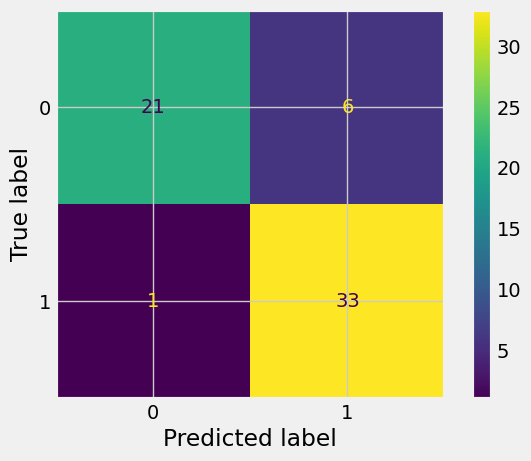

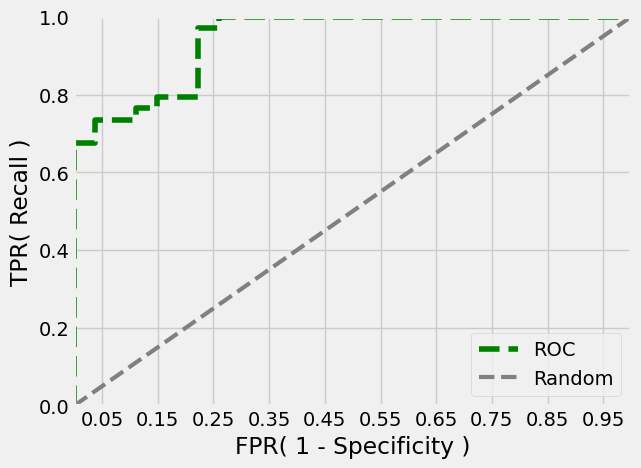

In [192]:
pred = lgb_model.predict(xtest)
pred_proba = lgb_model.predict_proba(xtest)[:, 1]
metrics_test_lgb = get_clf_eval(ytest.values, pred, pred_proba)

In [193]:

fig = go.Figure()
fig.add_trace(
    go.Table(columnwidth=[80,100],
             header=dict(values=['Metrics', 'LightGBM_Test'], height=50, font_size=22),
             cells=dict(values=[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC_AUC'],
                                [metrics_test_lgb['accuracy'].round(3), metrics_test_lgb['precision'].round(3), metrics_test_lgb['recall'].round(3), metrics_test_lgb['f1'].round(3), metrics_test_lgb['roc_auc'].round(3)]], height=50, font_size=16)))

fig.show()

# 9- Compare Models

Text(0.5, 1.0, 'Metrics')

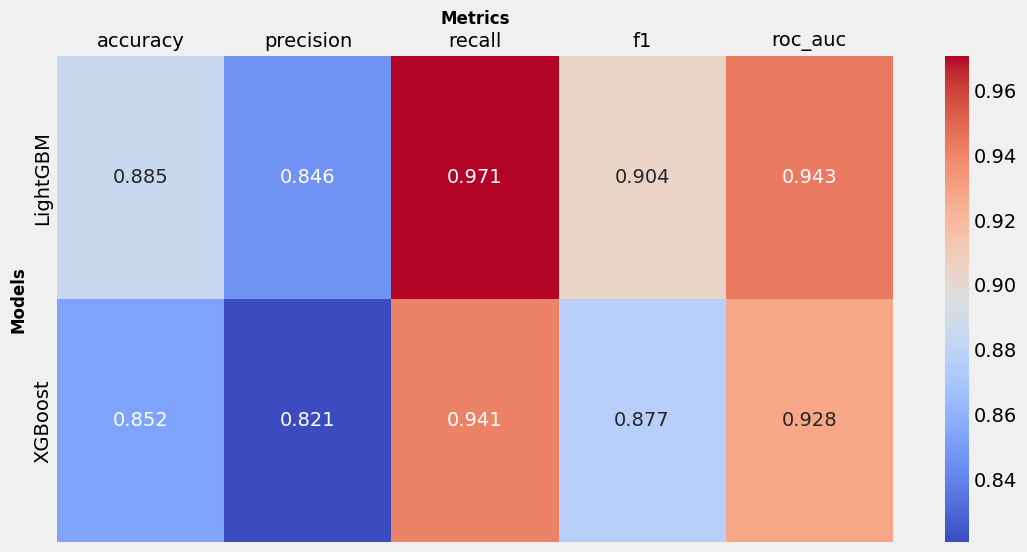

In [215]:
models_name = {'XGBoost': metrics_test_xgb, 'LightGBM': metrics_test_lgb}

df_test_metrics = pd.DataFrame.from_dict(models_name, orient='index')
df_test_metrics = df_test_metrics.sort_values('recall', ascending=False).sort_values('f1', ascending=False)

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(df_test_metrics, annot=True, cmap='coolwarm', fmt=".3f", ax=ax)
ax.xaxis.tick_top()
ax.set_ylabel('Models', fontsize=12, fontweight='bold')
ax.set_title('Metrics', fontsize=12, fontweight='bold')

In [218]:
cat_explainer = shap.TreeExplainer(xgb_model, xtrain, feature_names = xtrain.columns.tolist())
shap_values = cat_explainer.shap_values(xtrain, ytrain)
shap_values.shape

(241, 13)

# 10- Explainable AI Using SHAP Value

In [219]:
pd.DataFrame(pd.DataFrame(shap_values, columns=xtrain.columns.tolist()).abs().sum().sort_values(ascending=False), columns=["sum(|SHAP value|)"])

,sum(|SHAP value|)
cp,242.167201
caa,241.243231
thall,194.534497
oldpeak,172.308805
chol,124.003350
sex,116.471164
age,97.916511
thalachh,87.393385
slp,83.814132
trtbps,54.081665


## 10.1- SHAP Feature Importance Plot

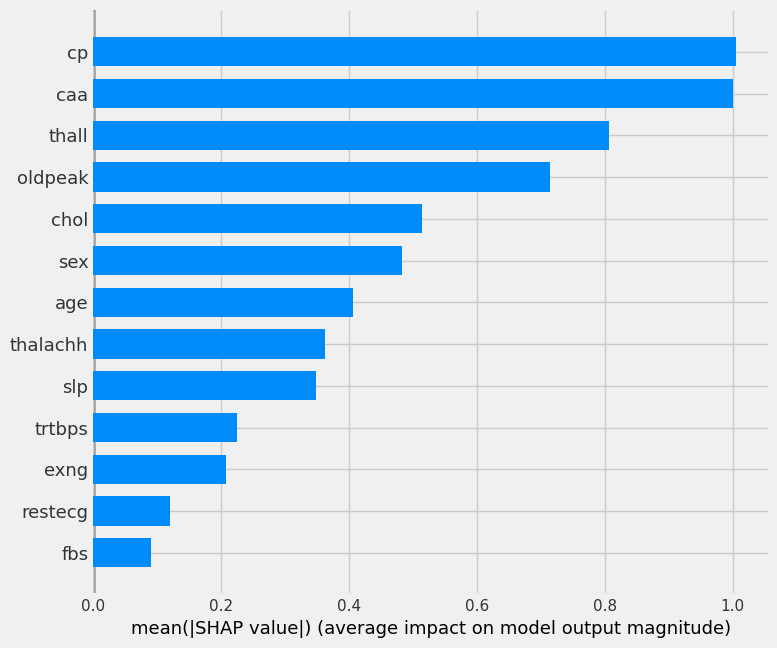

In [220]:
shap.summary_plot(shap_values, xtrain, feature_names=xtrain.columns, plot_type="bar")

# 10.2- SHAP Beeswarm Plot

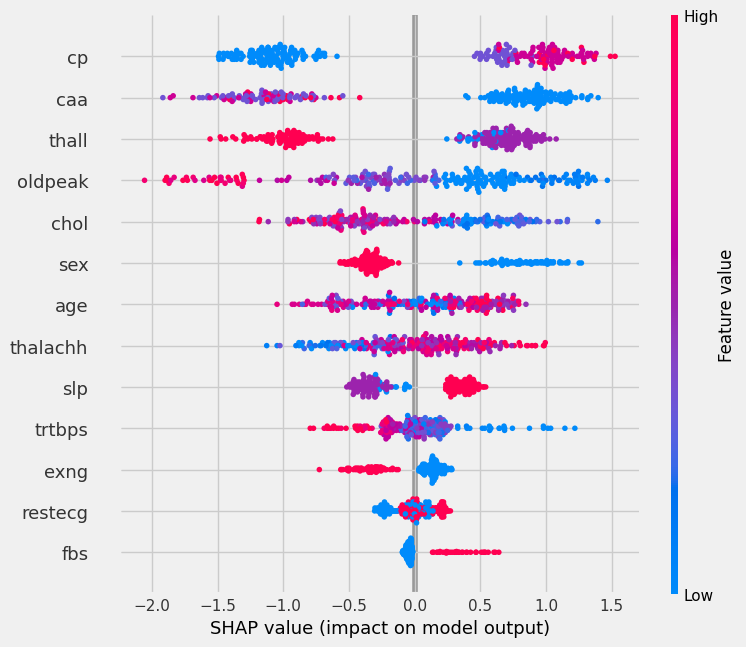

In [221]:
shap.summary_plot(shap_values, xtrain, feature_names=xtrain.columns)

## 10.3- SHAP Waterfall Plot & Force Plot

In [222]:
cat_explainer = shap.TreeExplainer(xgb_model, xtrain, feature_names = xtrain.columns.tolist())
shap_explainer_values = cat_explainer(xtrain, ytrain)

type(shap_explainer_values)

shap._explanation.Explanation

### Patient No.25

In [229]:
pd.DataFrame(xtrain.iloc[25])

,224
age,54.0
sex,1.0
cp,0.0
trtbps,110.0
chol,239.0
fbs,0.0
restecg,1.0
thalachh,126.0
exng,1.0
oldpeak,2.8


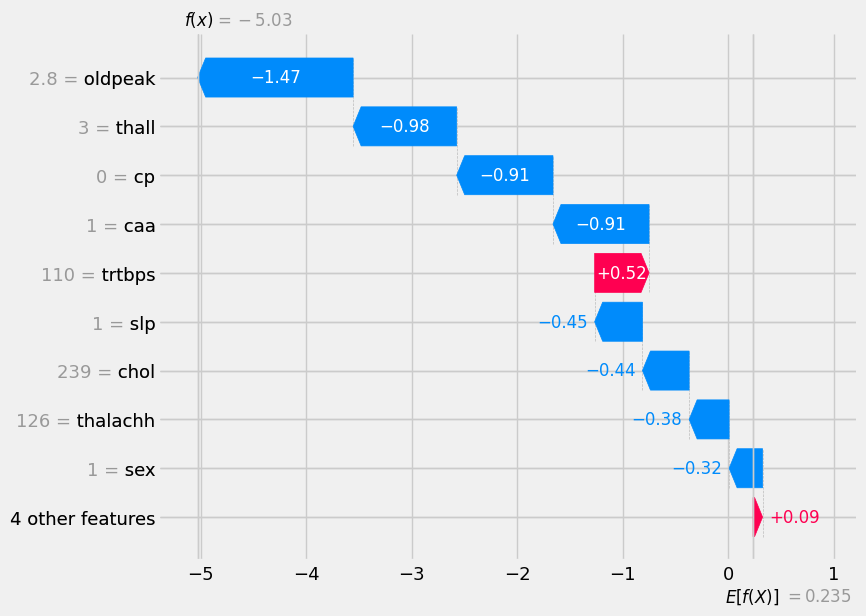

In [238]:
shap.waterfall_plot(shap_explainer_values[25])

In [239]:
shap.initjs()

shap.force_plot(shap_explainer_values[25])

In [244]:
xgb.save_model('XGB.h5')

In [259]:
xgb.score(xtest,ytest)

0.8524590163934426